<a href="https://colab.research.google.com/github/gkuch22/ml-final/blob/main/final_model_experiment_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch # Main PyTorch Library
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)


Device available:  cpu


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/train.csv')
stores_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/stores.csv')
features_df = pd.read_csv('/content/drive/MyDrive/cs231n/assignments/final/datasets/features.csv')

In [ ]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
stores_df.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [ ]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


#DATA MERGE

In [ ]:
features_df = features_df.drop(columns=["IsHoliday"])

In [ ]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [ ]:
merged_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how='left')
merged_df = pd.merge(merged_df, stores_df, on='Store', how='left')

In [ ]:
train_df.shape, stores_df.shape, features_df.shape, merged_df.shape

((421570, 5), (45, 3), (8190, 11), (421570, 16))

In [ ]:
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [ ]:
merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [ ]:
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Week'] = merged_df['Date'].dt.isocalendar().week.astype(int)

In [ ]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

# DATA SPLIT

In [ ]:
year_split = 2012
month_split = 6

train_df = merged_df[merged_df['Year'] < year_split]
valid_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] < month_split)]
test_df = merged_df[(merged_df['Year'] == year_split) & (merged_df['Month'] >= month_split)]

#DATA ANALYSIS

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         294132 non-null  int64         
 1   Dept          294132 non-null  int64         
 2   Date          294132 non-null  datetime64[ns]
 3   Weekly_Sales  294132 non-null  float64       
 4   IsHoliday     294132 non-null  bool          
 5   Temperature   294132 non-null  float64       
 6   Fuel_Price    294132 non-null  float64       
 7   MarkDown1     23700 non-null   float64       
 8   MarkDown2     20154 non-null   float64       
 9   MarkDown3     23116 non-null   float64       
 10  MarkDown4     21042 non-null   float64       
 11  MarkDown5     23994 non-null   float64       
 12  CPI           294132 non-null  float64       
 13  Unemployment  294132 non-null  float64       
 14  Type          294132 non-null  object        
 15  Size          294132 n

In [ ]:
print(train_df.describe())

               Store           Dept                           Date  \
count  294132.000000  294132.000000                         294132   
mean       22.180178      44.184135  2011-01-18 08:32:17.546407680   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-07-30 00:00:00   
50%        22.000000      37.000000            2011-01-21 00:00:00   
75%        33.000000      72.000000            2011-07-15 00:00:00   
max        45.000000      99.000000            2011-12-30 00:00:00   
std        12.780170      30.430023                            NaN   

        Weekly_Sales    Temperature     Fuel_Price     MarkDown1  \
count  294132.000000  294132.000000  294132.000000  23700.000000   
mean    16105.306895      58.909079       3.209664   4534.018155   
min     -4988.940000      -2.060000       2.472000      0.500000   
25%      2146.025000      45.260000       2.808000    759.800000   
50%      7727.310000      60.

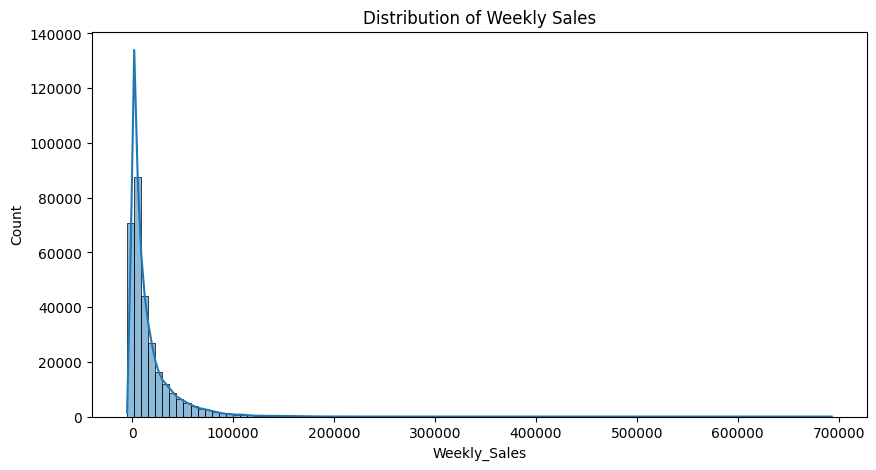

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['Weekly_Sales'], bins=100, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

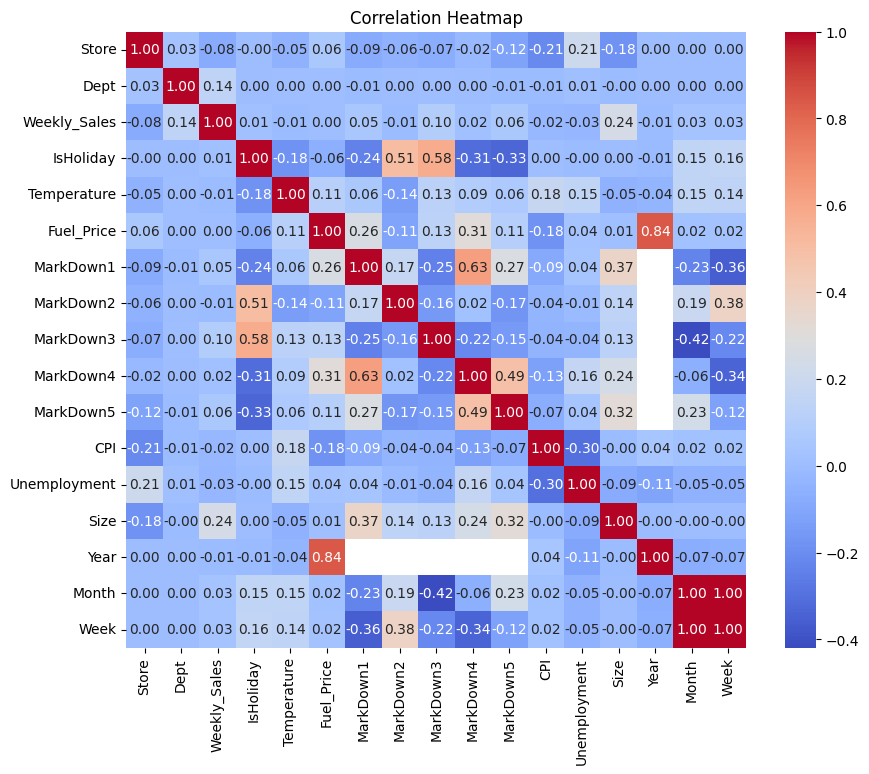

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

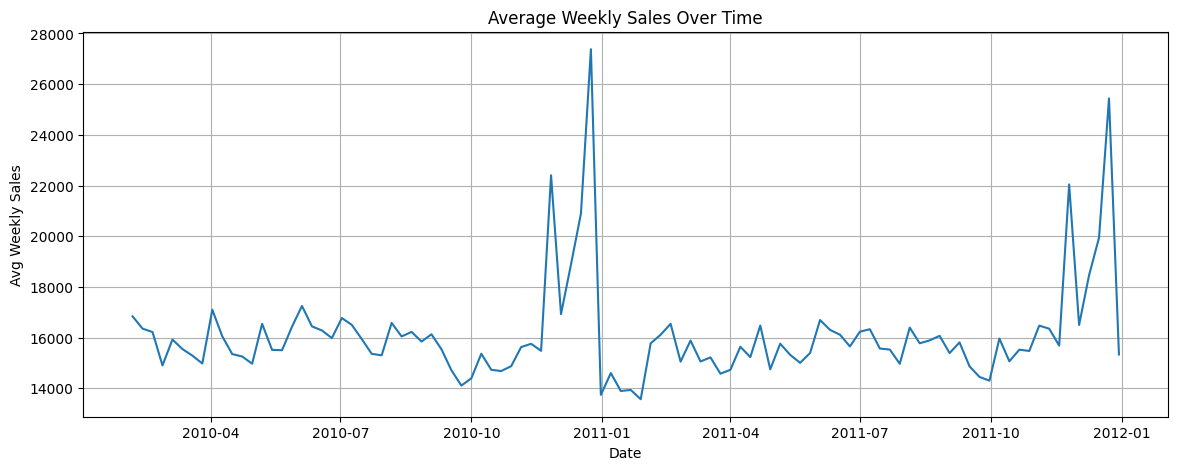

In [ ]:
weekly_trend = train_df.groupby('Date')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(weekly_trend['Date'], weekly_trend['Weekly_Sales'])
plt.title("Average Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Weekly Sales")
plt.grid(True)
plt.show()

In [ ]:
holiday_effect = train_df.groupby(['Store', 'IsHoliday'])['Weekly_Sales'].mean().unstack()
holiday_effect['Diff'] = holiday_effect[True] - holiday_effect[False]
holiday_effect = holiday_effect.sort_values('Diff', ascending=False)

print("stores with biggest sales diffs during holidays:\n", holiday_effect.head())

stores with biggest sales diffs during holidays:
 IsHoliday         False          True         Diff
Store                                             
10         26425.441209  29622.513614  3197.072406
35         14283.811914  16652.097346  2368.285431
4          28634.041434  30809.726598  2175.685164
2          26918.251461  29049.427768  2131.176307
12         14753.974123  16868.240055  2114.265932


In [ ]:
dept_holiday_effect = train_df.groupby(['Store', 'Dept', 'IsHoliday'])['Weekly_Sales'].mean().unstack()
dept_holiday_effect['Diff'] = dept_holiday_effect[True] - dept_holiday_effect[False]
dept_holiday_effect = dept_holiday_effect.sort_values('Diff', ascending=False)

print("depts with biggest sales diffs during holidays:\n", dept_holiday_effect.head())

depts with biggest sales diffs during holidays:
 IsHoliday           False          True           Diff
Store Dept                                            
35    72     83936.409022  234190.36750  150253.958478
10    72    141433.481522  286387.82625  144954.344728
20    72     91750.394239  182474.68625   90724.292011
27    72     68745.703696  155739.93000   86994.226304
14    72     95617.223587  180358.95625   84741.732663


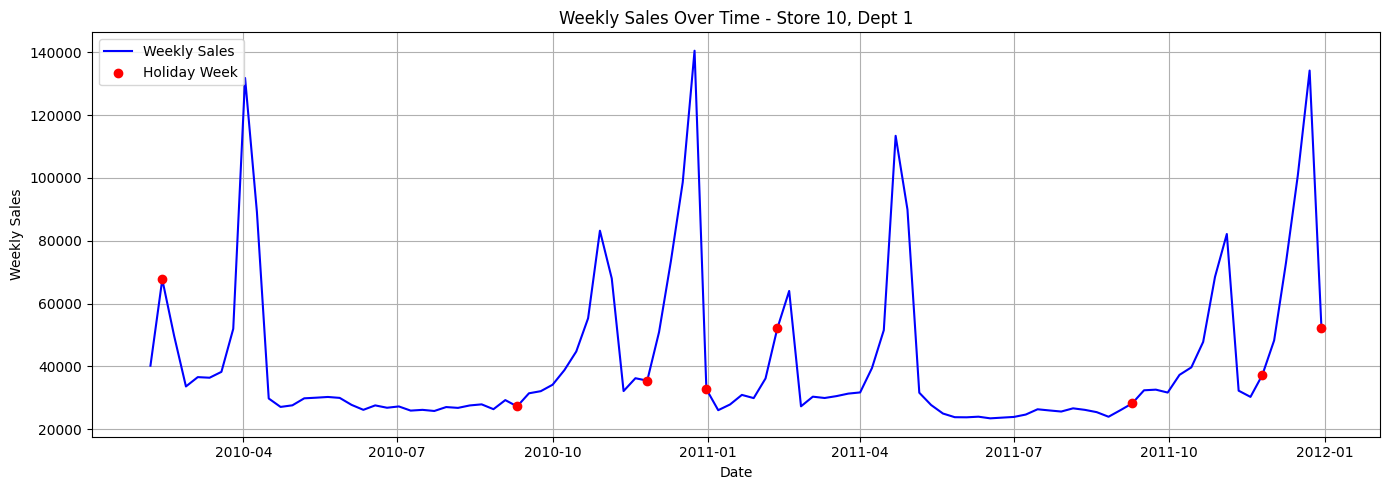

In [ ]:
store_id = 10
dept_id = 1
subset = train_df[(train_df['Store'] == store_id) & (train_df['Dept'] == dept_id)]

subset = subset.sort_values('Date')

plt.figure(figsize=(14, 5))
plt.plot(subset['Date'], subset['Weekly_Sales'], label='Weekly Sales', color='blue')

holiday_dates = subset[subset['IsHoliday'] == True]['Date']
holiday_sales = subset[subset['IsHoliday'] == True]['Weekly_Sales']
plt.scatter(holiday_dates, holiday_sales, color='red', label='Holiday Week', zorder=5)

plt.title(f"Weekly Sales Over Time - Store {store_id}, Dept {dept_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FEATURE ENGINEERING

In [ ]:
def add_weeks_to_new_year(df, new_year_dates):
    df = df.copy()
    df['WeeksToNewYear'] = 0
    for date_str in new_year_dates:
        event_date = pd.to_datetime(date_str)
        for i in range(1, 4):
            shifted_date = event_date - pd.Timedelta(weeks=i)
            condition = df['Date'] == shifted_date
            column = 'WeeksToNewYear'
            df.loc[condition, column] = i
    return df

new_year_dates = ['2010-12-31', '2011-12-30']

train_df = add_weeks_to_new_year(train_df, new_year_dates)
valid_df = add_weeks_to_new_year(valid_df, new_year_dates)
test_df = add_weeks_to_new_year(test_df, new_year_dates)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           294132 non-null  int64         
 1   Dept            294132 non-null  int64         
 2   Date            294132 non-null  datetime64[ns]
 3   Weekly_Sales    294132 non-null  float64       
 4   IsHoliday       294132 non-null  bool          
 5   Temperature     294132 non-null  float64       
 6   Fuel_Price      294132 non-null  float64       
 7   MarkDown1       23700 non-null   float64       
 8   MarkDown2       20154 non-null   float64       
 9   MarkDown3       23116 non-null   float64       
 10  MarkDown4       21042 non-null   float64       
 11  MarkDown5       23994 non-null   float64       
 12  CPI             294132 non-null  float64       
 13  Unemployment    294132 non-null  float64       
 14  Type            294132 non-null  object  

In [ ]:
holiday_lift = holiday_effect['Diff']

train_df['StoreHolidayLift'] = train_df['Store'].map(holiday_lift).fillna(0)
valid_df['StoreHolidayLift'] = valid_df['Store'].map(holiday_lift).fillna(0)
test_df['StoreHolidayLift'] = test_df['Store'].map(holiday_lift).fillna(0)

In [ ]:
dept_holiday_effect = train_df.groupby(['Store', 'Dept', 'IsHoliday'])['Weekly_Sales'].mean().unstack()
dept_holiday_effect['Diff'] = dept_holiday_effect.get(True, 0) - dept_holiday_effect.get(False, 0)

dept_holiday_lift = dept_holiday_effect['Diff']
train_df['DeptHolidayLift'] = train_df.set_index(['Store', 'Dept']).index.map(dept_holiday_lift).fillna(0)
valid_df['DeptHolidayLift'] = valid_df.set_index(['Store', 'Dept']).index.map(dept_holiday_lift).fillna(0)
test_df['DeptHolidayLift'] = test_df.set_index(['Store', 'Dept']).index.map(dept_holiday_lift).fillna(0)

In [ ]:
train_df['DeptHolidayLift'].unique()

array([ 2478.68445652, -2325.91173913, -2405.36766304, ...,
       -6210.64565217,  -448.34891304,   -17.84345238])

In [ ]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,CPI,Unemployment,Type,Size,Year,Month,Week,WeeksToNewYear,StoreHolidayLift,DeptHolidayLift
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,...,211.096358,8.106,A,151315,2010,2,5,0,1474.516021,2478.684457
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,...,211.242170,8.106,A,151315,2010,2,6,0,1474.516021,2478.684457
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,...,211.289143,8.106,A,151315,2010,2,7,0,1474.516021,2478.684457
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,...,211.319643,8.106,A,151315,2010,2,8,0,1474.516021,2478.684457
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,...,211.350143,8.106,A,151315,2010,3,9,0,1474.516021,2478.684457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421522,45,98,2011-12-02,538.51,False,50.19,3.452,6835.61,120.76,802.79,...,188.502435,8.523,B,118221,2011,12,48,0,734.139966,-17.843452
421523,45,98,2011-12-09,572.72,False,46.57,3.415,6176.69,2.87,379.57,...,188.654469,8.523,B,118221,2011,12,49,3,734.139966,-17.843452
421524,45,98,2011-12-16,853.46,False,39.93,3.413,4631.26,8.92,801.34,...,188.797935,8.523,B,118221,2011,12,50,2,734.139966,-17.843452
421525,45,98,2011-12-23,1084.78,False,42.27,3.389,797.10,89.14,1962.19,...,188.929975,8.523,B,118221,2011,12,51,1,734.139966,-17.843452


In [ ]:
def add_holiday_lag_features(df):
    df = df.sort_values(by=['Store', 'Dept', 'Date'])
    df['HolidayLag1'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(1).fillna(False).astype(bool)
    df['HolidayLag2'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(2).fillna(False).astype(bool)
    df['HolidayNext1'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(-1).fillna(False).astype(bool)
    df['HolidayNext2'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(-2).fillna(False).astype(bool)
    return df

train_df = add_holiday_lag_features(train_df)
valid_df = add_holiday_lag_features(valid_df)
test_df = add_holiday_lag_features(test_df)

/tmp/ipython-input-30-4125679893.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HolidayLag1'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(1).fillna(False).astype(bool)
/tmp/ipython-input-30-4125679893.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HolidayLag2'] = df.groupby(['Store', 'Dept'])['IsHoliday'].shift(2).fillna(False).astype(bool)
/tmp/ipython-input-30-4125679893.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(co

In [ ]:
def add_sales_lag_features(df):
    df = df.sort_values(by=['Store', 'Dept', 'Date'])
    df['SalesLag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
    df['SalesLag2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
    df['SalesLag4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
    return df

train_df = add_sales_lag_features(train_df)
valid_df = add_sales_lag_features(valid_df)
test_df = add_sales_lag_features(test_df)

# DATA PREPROCESSING

In [ ]:
train_df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_type_encoded = onehot_encoder.fit_transform(train_df[['Type']])
encoded_cols = onehot_encoder.get_feature_names_out(['Type'])
train_type_df = pd.DataFrame(train_type_encoded, columns=encoded_cols, index=train_df.index)

valid_type_encoded = onehot_encoder.transform(valid_df[['Type']])
valid_type_df = pd.DataFrame(valid_type_encoded, columns=encoded_cols, index=valid_df.index)

test_type_encoded = onehot_encoder.transform(test_df[['Type']])
test_type_df = pd.DataFrame(test_type_encoded, columns=encoded_cols, index=test_df.index)

train_df = train_df.drop(columns='Type')
train_df = pd.concat([train_df, train_type_df], axis=1)

valid_df = valid_df.drop(columns='Type')
valid_df = pd.concat([valid_df, valid_type_df], axis=1)

test_df = test_df.drop(columns='Type')
test_df = pd.concat([test_df, test_type_df], axis=1)

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             294132 non-null  int64         
 1   Dept              294132 non-null  int64         
 2   Date              294132 non-null  datetime64[ns]
 3   Weekly_Sales      294132 non-null  float64       
 4   IsHoliday         294132 non-null  bool          
 5   Temperature       294132 non-null  float64       
 6   Fuel_Price        294132 non-null  float64       
 7   MarkDown1         23700 non-null   float64       
 8   MarkDown2         20154 non-null   float64       
 9   MarkDown3         23116 non-null   float64       
 10  MarkDown4         21042 non-null   float64       
 11  MarkDown5         23994 non-null   float64       
 12  CPI               294132 non-null  float64       
 13  Unemployment      294132 non-null  float64       
 14  Size     

In [ ]:
from sklearn.impute import SimpleImputer

na_cols = [col for col in train_df.columns if train_df[col].isna().sum() > 0]
imputer = SimpleImputer(strategy='mean')
train_df[na_cols] = imputer.fit_transform(train_df[na_cols])

valid_df[na_cols] = imputer.transform(valid_df[na_cols])
test_df[na_cols] = imputer.transform(test_df[na_cols])

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             294132 non-null  int64         
 1   Dept              294132 non-null  int64         
 2   Date              294132 non-null  datetime64[ns]
 3   Weekly_Sales      294132 non-null  float64       
 4   IsHoliday         294132 non-null  bool          
 5   Temperature       294132 non-null  float64       
 6   Fuel_Price        294132 non-null  float64       
 7   MarkDown1         294132 non-null  float64       
 8   MarkDown2         294132 non-null  float64       
 9   MarkDown3         294132 non-null  float64       
 10  MarkDown4         294132 non-null  float64       
 11  MarkDown5         294132 non-null  float64       
 12  CPI               294132 non-null  float64       
 13  Unemployment      294132 non-null  float64       
 14  Size     

# SPLIT

In [ ]:
train_df = train_df.drop(columns=['Date'])
valid_df = valid_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

In [ ]:
y_train = train_df['Weekly_Sales']
X_train = train_df.drop(columns='Weekly_Sales')

y_valid = valid_df['Weekly_Sales']
X_valid = valid_df.drop(columns='Weekly_Sales')

y_test = test_df['Weekly_Sales']
X_test = test_df.drop(columns='Weekly_Sales')

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

((294132, 29), (62357, 29), (65081, 29))

In [ ]:
X_train

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,HolidayLag1,HolidayLag2,HolidayNext1,HolidayNext2,SalesLag1,SalesLag2,SalesLag4,Type_A,Type_B,Type_C
0,1,1,False,42.31,2.572,4534.018155,7808.916193,8259.218705,1531.493447,6393.284052,...,False,False,True,False,16129.731953,16044.93004,16000.309906,1.0,0.0,0.0
1,1,1,True,38.51,2.548,4534.018155,7808.916193,8259.218705,1531.493447,6393.284052,...,False,False,False,False,24924.500000,16044.93004,16000.309906,1.0,0.0,0.0
2,1,1,False,39.93,2.514,4534.018155,7808.916193,8259.218705,1531.493447,6393.284052,...,True,False,False,False,46039.490000,24924.50000,16000.309906,1.0,0.0,0.0
3,1,1,False,46.63,2.561,4534.018155,7808.916193,8259.218705,1531.493447,6393.284052,...,False,True,False,False,41595.550000,46039.49000,16000.309906,1.0,0.0,0.0
4,1,1,False,46.50,2.625,4534.018155,7808.916193,8259.218705,1531.493447,6393.284052,...,False,False,False,False,19403.540000,41595.55000,24924.500000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421522,45,98,False,50.19,3.452,6835.610000,120.760000,802.790000,2490.150000,17861.500000,...,True,False,False,False,794.620000,503.20000,749.180000,0.0,1.0,0.0
421523,45,98,False,46.57,3.415,6176.690000,2.870000,379.570000,1593.440000,10170.500000,...,False,True,False,False,538.510000,794.62000,897.220000,0.0,1.0,0.0
421524,45,98,False,39.93,3.413,4631.260000,8.920000,801.340000,848.330000,2757.820000,...,False,False,False,True,572.720000,538.51000,503.200000,0.0,1.0,0.0
421525,45,98,False,42.27,3.389,797.100000,89.140000,1962.190000,17.000000,2985.510000,...,False,False,True,False,853.460000,572.72000,794.620000,0.0,1.0,0.0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Store             294132 non-null  int64  
 1   Dept              294132 non-null  int64  
 2   IsHoliday         294132 non-null  bool   
 3   Temperature       294132 non-null  float64
 4   Fuel_Price        294132 non-null  float64
 5   MarkDown1         294132 non-null  float64
 6   MarkDown2         294132 non-null  float64
 7   MarkDown3         294132 non-null  float64
 8   MarkDown4         294132 non-null  float64
 9   MarkDown5         294132 non-null  float64
 10  CPI               294132 non-null  float64
 11  Unemployment      294132 non-null  float64
 12  Size              294132 non-null  int64  
 13  Year              294132 non-null  int32  
 14  Month             294132 non-null  int32  
 15  Week              294132 non-null  int64  
 16  WeeksToNewYear    294132 

# MODEL TRAINING

In [ ]:
def get_wmae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

train wmae: 1101.95
valid wmae: 1952.50



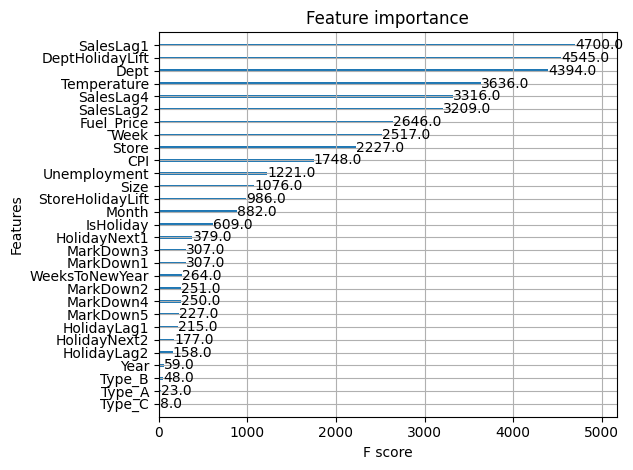

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    reg_lambda=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

weights_train = np.where(X_train['IsHoliday'], 5, 1)
weights_valid = np.where(X_valid['IsHoliday'], 5, 1)

train_score = get_wmae(y_train.values, y_pred_train, weights_train)
valid_score = get_wmae(y_valid.values, y_pred_valid, weights_valid)

print(f"train wmae: {train_score:.2f}")
print(f"valid wmae: {valid_score:.2f}")
print()

xgb.plot_importance(model)
plt.tight_layout()


# MLFLOW TRACKING

In [ ]:
!pip install dagshub mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import dagshub
import mlflow

dagshub.init(repo_owner='gkuch22', repo_name='ml-final', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=01c5536f-2842-408c-b915-52f1e01877f0&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9a267fb03a1ea3acfc90a2795e1c49e9e385668f32edce7acac4f795c53868e2




Accessing as gkuch22

Initialized MLflow to track repo "gkuch22/ml-final"

Repository gkuch22/ml-final initialized!

In [ ]:
experiment_name = "XGBoost_train"
run_name = "hyperparameters_tuned"

train wmae: 1101.95
valid wmae: 1952.50
🏃 View run hyperparameters_tuned at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/2/runs/eff282a4039c4c748ab22fcc39bc629d
🧪 View experiment at: https://dagshub.com/gkuch22/ml-final.mlflow/#/experiments/2


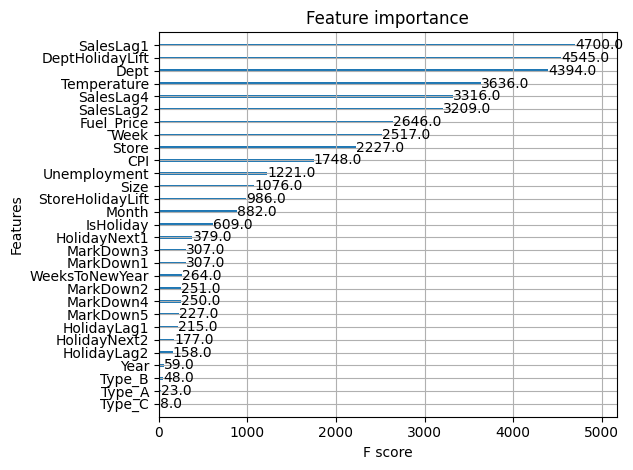

In [ ]:
import mlflow
import xgboost as xgb

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("learning_rate", 0.2)
    mlflow.log_param("max_depth", 8)
    mlflow.log_param("reg_lambda", 0.5)
    mlflow.log_param("data", "merged")
    mlflow.log_param("num_features", X_train.shape[1])

    mlflow.log_param("model_type", "XGBoost")

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.2,
        max_depth=8,
        reg_lambda=0.5,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    )

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    weights_train = np.where(X_train['IsHoliday'], 5, 1)
    weights_valid = np.where(X_valid['IsHoliday'], 5, 1)

    train_wmae = get_wmae(y_train.values, y_pred_train, weights_train)
    valid_wmae = get_wmae(y_valid.values, y_pred_valid, weights_valid)

    print(f"train wmae: {train_wmae:.2f}")
    print(f"valid wmae: {valid_wmae:.2f}")

    mlflow.log_metric("train_wmae", train_wmae)
    mlflow.log_metric("valid_wmae", valid_wmae)

    # mlflow.sklearn.log_model(model, "model")

    xgb.plot_importance(model)
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")
